In [2]:
import sys

sys.path.append('../')

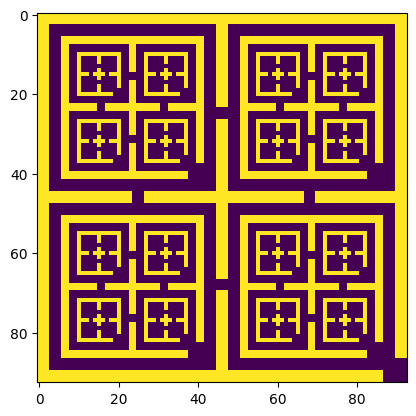

In [3]:
import numpy as np
import graphviz
from IPython.display import display
from environments.tree.tree import NaryTreeEnvironment
from environments.tree.data import TrajectoryDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor

import argparse
from environments.tree.data import TrajectoryDataset
from networks.hypnets import HyperbolicMLP, manifold_map
from networks.nets import SmallEncoder
from utils import get_maze, load_model, load_tree_model
import os
import json


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# directory w/ pretrained weights
# saved = '/home/yongweic/hyperbolic/saved_models/tree_experiment2_hyperbolic_True_curvature_1.0_learnable_False_epochs_256_trajectories_10000_depth_6_branch_3_embeddingdim_2_gamma_0.1_batch_128'
saved = '/home/yongweic/hyperbolic/saved_models/tree_experiment2_hyperbolic_True_curvature_1.0_learnable_False_epochs_128_trajectories_10000_depth_6_branch_2_embeddingdim_2_gamma_0.1_batch_128'
saved = '/home/yongweic/hyperbolic/saved_models/tree_experiment2_hyperbolic_True_curvature_1.0_learnable_False_epochs_256_trajectories_10000_depth_6_branch_2_embeddingdim_2_gamma_0.5_batch_128'

# symmetric
saved = '/home/yongweic/hyperbolic/saved_models/tree_experiment2_hyperbolic_True_symmetric_False_curvature_1.0_learnable_False_epochs_256_trajectories_10000_depth_6_branch_2_embeddingdim_2_gamma_0.2_batch_128'
saved = '/home/yongweic/hyperbolic/saved_models/tree_experimentarray_hyperbolic_True_symmetric_False_curvature_1.0_learnable_True_epochs_512_trajectories_25000_depth_9_branch_2_embeddingdim_2_gamma_0.1_batch_512'
config = json.load(open(os.path.join(saved, 'config.json')))
print(config)

branching_factor = config['branching_factor']
depth = config['depth']

env = NaryTreeEnvironment(depth=depth, branching_factor=branching_factor)
hyperbolic = config['hyperbolic']
model_dict = load_tree_model(config, device, pretrained_path=saved, epoch=304)

encoder1 = model_dict['encoder1']
encoder2 = model_dict['encoder2']
manifold = model_dict['manifold']


{'project': 'tree_arr', 'custom': 'array', 'hyperbolic': True, 'embedding_dim': 2, 'curvature': 1.0, 'learnable_curvature': True, 'num_epochs': 512, 'num_trajectories': 25000, 'batch_size': 512, 'num_negatives': 128, 'max_steps': 100, 'num_workers': 24, 'learning_rate': 0.01, 'depth': 9, 'branching_factor': 2, 'gamma': 0.1, 'order_name': '', 'eval_trials': 100, 'temperature': 0.1, 'architecture': 'MLP', 'symmetric': False}
loading pretrained...


Node path from 12 to 6: [12, 5, 2, 6]
[0, 0, 2]
Action path from 12 to 6: [(12, 0), (5, 0), (2, 2), (6, 3)]


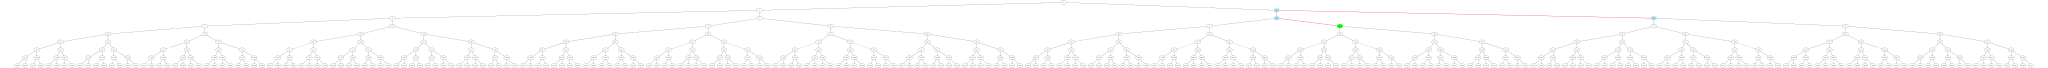

After action 0:


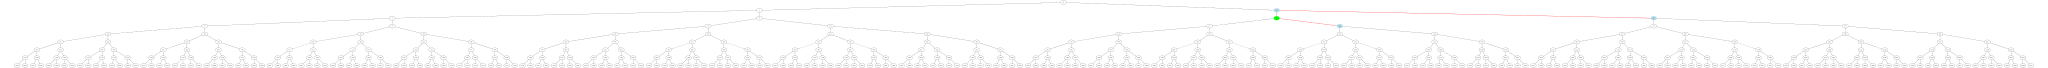

After action 0:


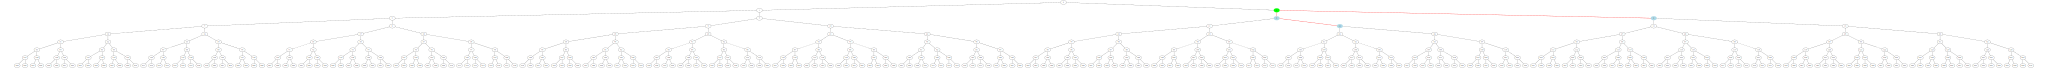

After action 2:


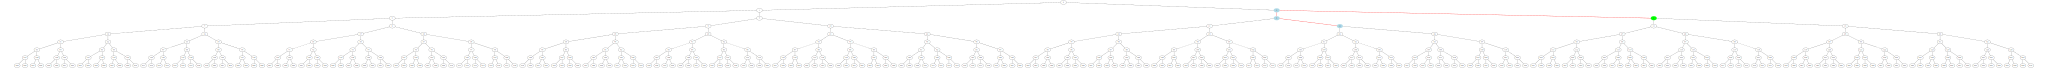

In [6]:
env = NaryTreeEnvironment(depth=depth, branching_factor=branching_factor)

# Choose two nodes
start_node = 12
end_node = 6

# Get the node path
node_path = env.get_node_path(start_node, end_node)
print(f"Node path from {start_node} to {end_node}: {node_path}")

# Get the action path
action_path = env.get_action_path(start_node, end_node)
actions = [x[1] for x in action_path][:-1]
print(actions)

print(f"Action path from {start_node} to {end_node}: {action_path}")

# Display the tree with highlighted path
env.agent_position = start_node
env.display(highlight_path=node_path)

for action in actions:
    env.move_agent(action)
    print(f"After action {action}:")
    env.display(highlight_path=node_path)


In [7]:
ds = TrajectoryDataset(depth, branching_factor, 100)

gamma: 0.1


0 1
1 3
3 7
7 15
15 31
31 63
63 127
127 255
255 511


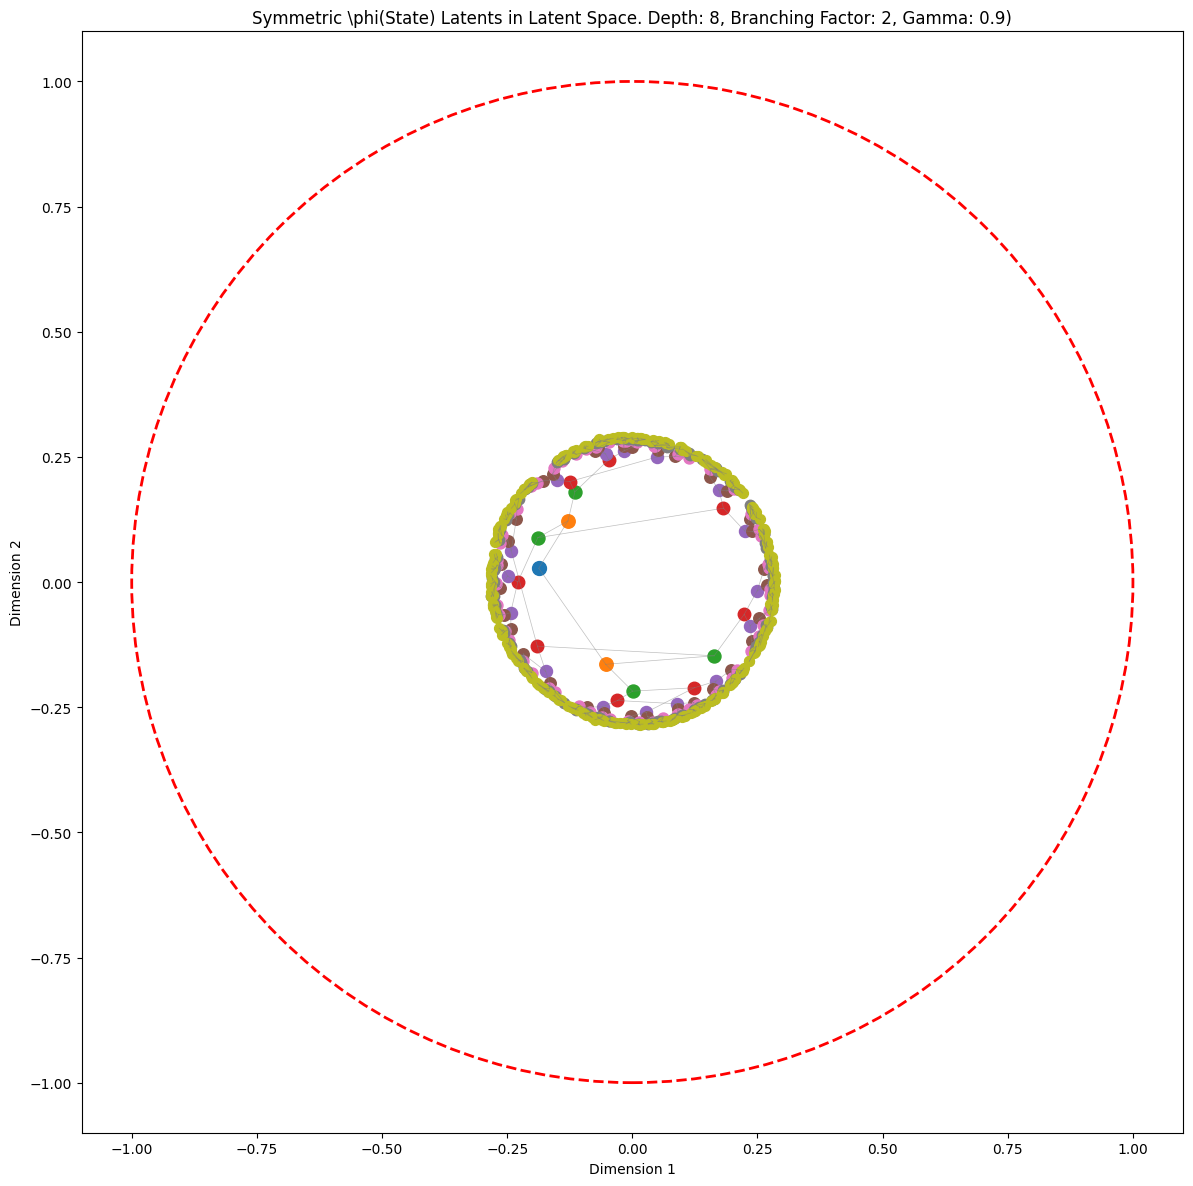

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
    nodes = torch.arange(env.num_nodes)[:, None]
    latents = encoder2(nodes)
    if hyperbolic:
        latents = latents.tensor


max_depth = int(np.log(env.num_nodes) / np.log(branching_factor))
sizes = np.linspace(100, 50, max_depth + 1)  # Decreasing sizes from 100 to 50

plt.figure(figsize=(12, 12))  # Make it square

if hyperbolic:
    # Plot the unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', linewidth=2)
    plt.gca().add_artist(circle)

# Plot lines connecting parents to children
for node in range(1, env.num_nodes):  # Start from 1 to skip the root
    parent = (node - 1) // branching_factor
    plt.plot([latents[parent, 0], latents[node, 0]], 
             [latents[parent, 1], latents[node, 1]], 
             color='gray', alpha=0.5, linewidth=0.5)

    
# Plot nodes
l = 0
for i in range(max_depth + 1):
    r = l + branching_factor**i
    print(l, r)
    plt.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])
    l = r

plt.title(f"Symmetric \phi(State) Latents in Latent Space. Depth: {max_depth}, Branching Factor: {branching_factor}, Gamma: {1 - config['gamma']})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.axis('equal')  # This ensures the circle is circular and not elliptical
if hyperbolic:
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')  # This ensures the aspect ratio stays constant
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def mobius_addition(z1, z2, theta=0):
    numerator = z1 + np.exp(1j * theta) * z2
    denominator = 1 + np.conj(z1) * np.exp(1j * theta) * z2
    return numerator / denominator

def geodesic_points(z1, z2, t):
    a = mobius_addition(-z1, z2, 0)  # theta=0 for geodesics
    return mobius_addition(z1, t * a, 0)

def plot_latents(ax, latents, title='', g_points=None):
        if hyperbolic:
            circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', linewidth=2)
            ax.add_artist(circle)

        for node in range(1, env.num_nodes):
            parent = (node - 1) // branching_factor
            ax.plot([latents[parent, 0], latents[node, 0]], 
                    [latents[parent, 1], latents[node, 1]], 
                    color='gray', alpha=0.5, linewidth=0.5)

        for i in range(max_depth + 1):
            l = branching_factor**i - 1
            r = min(branching_factor**(i + 1), env.num_nodes)
            ax.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])
            
            
        if g_points is not None:
            p1, p2 = g_points
            z1 = p1[0] + 1j*p1[1]
            z2 = p2[0] + 1j*p2[1]
            print(z1, z2)
            t = np.linspace(0, 1, 100)
            geodesic = geodesic_points(z1, z2, t)

            # Plot the geodesic
            ax.plot(geodesic.real, geodesic.imag, 'r-')


        ax.set_title(title)
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        ax.axis('equal')
        if hyperbolic:
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
        ax.set_aspect('equal', adjustable='box')

(-0.005017539486289024+0.3050658702850342j) (-0.24387428164482117+0.18256138265132904j)
(-0.18570874631404877-0.07571186870336533j) (0.07834986597299576-0.29482409358024597j)
(0.2404680997133255-0.18617433309555054j) (0.18374057114124298+0.24377407133579254j)
(-0.04727039858698845-0.30187225341796875j) (-0.07986462116241455-0.2937701940536499j)
(0.011994139291346073-0.30613088607788086j) (-0.28998884558677673+0.09460859000682831j)
(-0.22456520795822144-0.20048171281814575j) (0.2860562205314636-0.10083115845918655j)


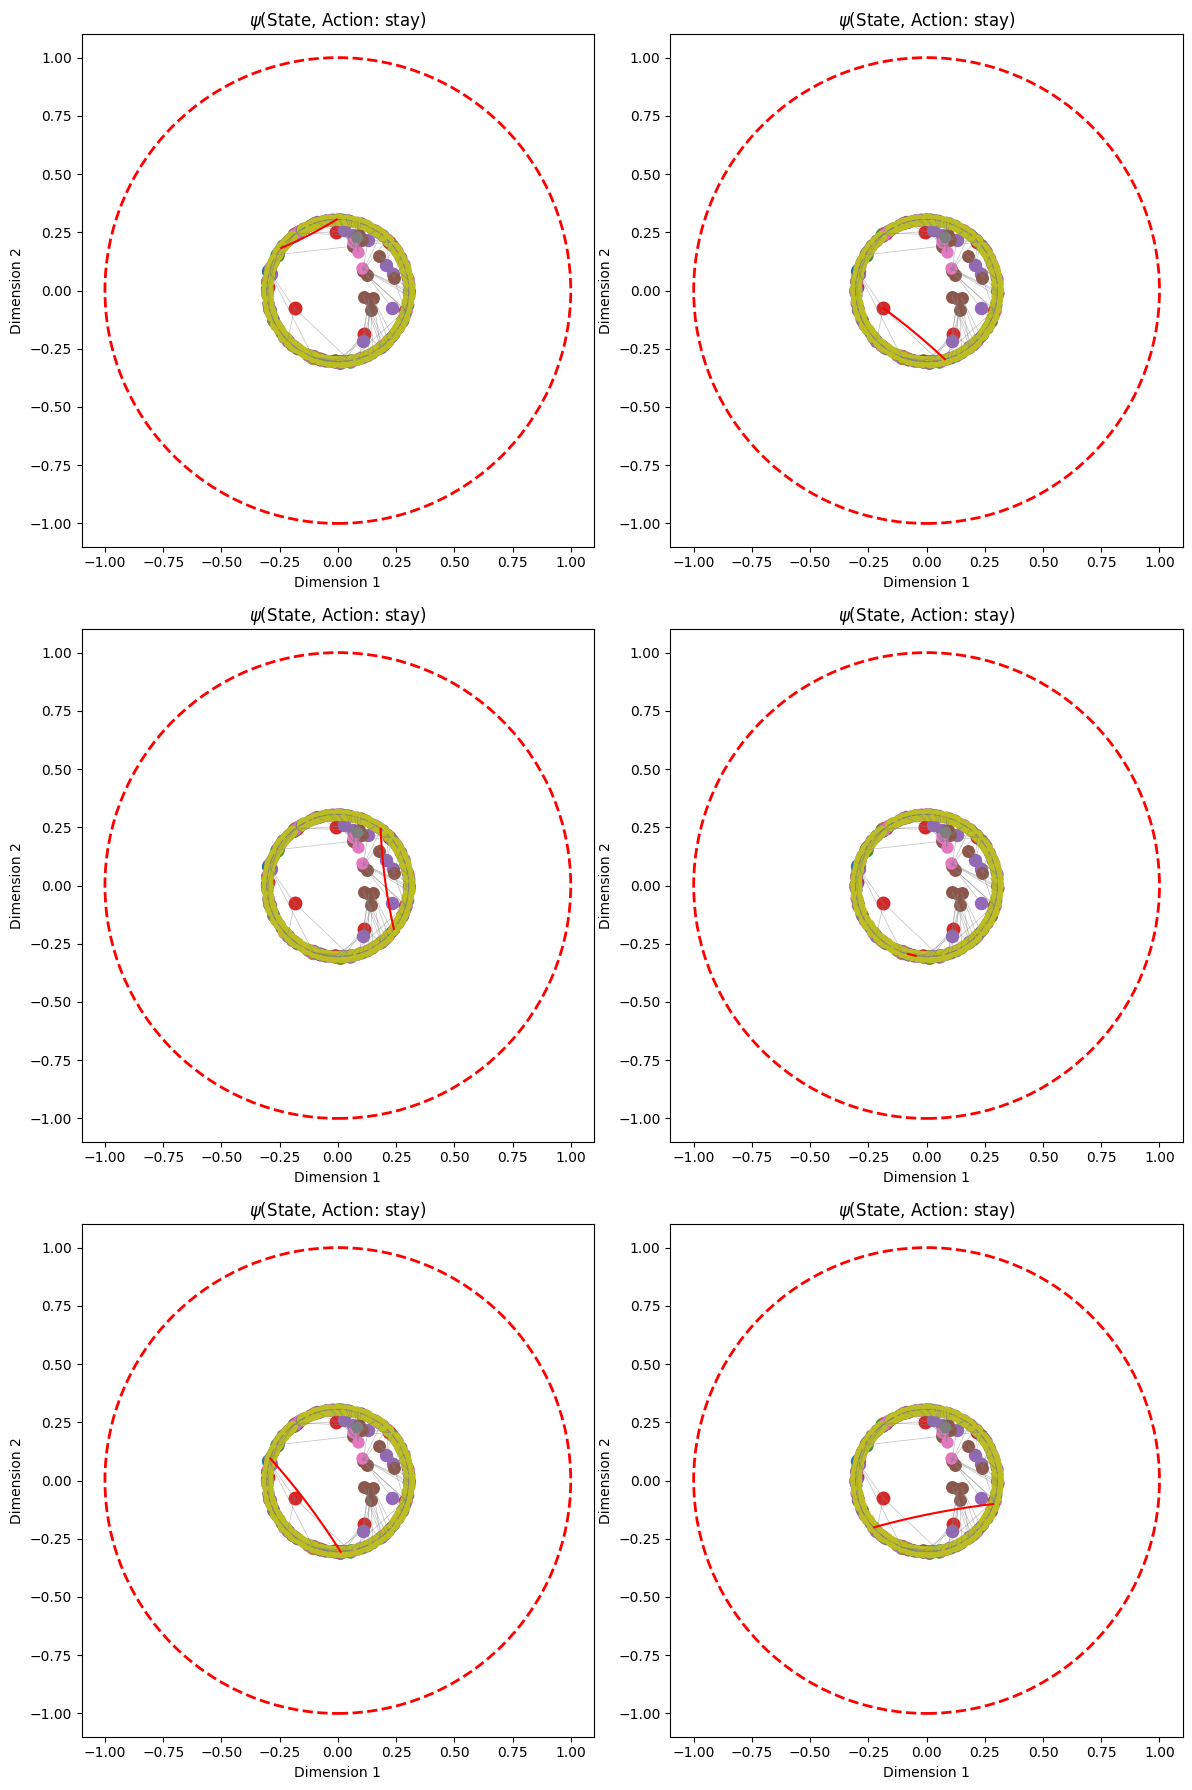

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

a = 3
with torch.no_grad():
    for i in range(6):
        action_name = env.action_map[a]
        nodes = torch.arange(env.num_nodes)[:, None]
        actions = torch.cat([nodes, torch.full(nodes.shape, a)], dim=-1)
        latents = encoder1(actions)
        if hyperbolic:
            latents = latents.tensor
        
        # Generate random indices for g_points
        idx1, idx2 = torch.randint(0, env.num_nodes, (2,))
        g_p1 = tuple([float(x) for x in latents[idx1]])
        g_p2 = tuple([float(x) for x in latents[idx2]])
        
        plot_latents(axes[i], 
                     latents, 
                     title=f"$\psi$(State, Action: {action_name})", 
                     g_points=([g_p1, g_p2]))

plt.tight_layout()
plt.show()

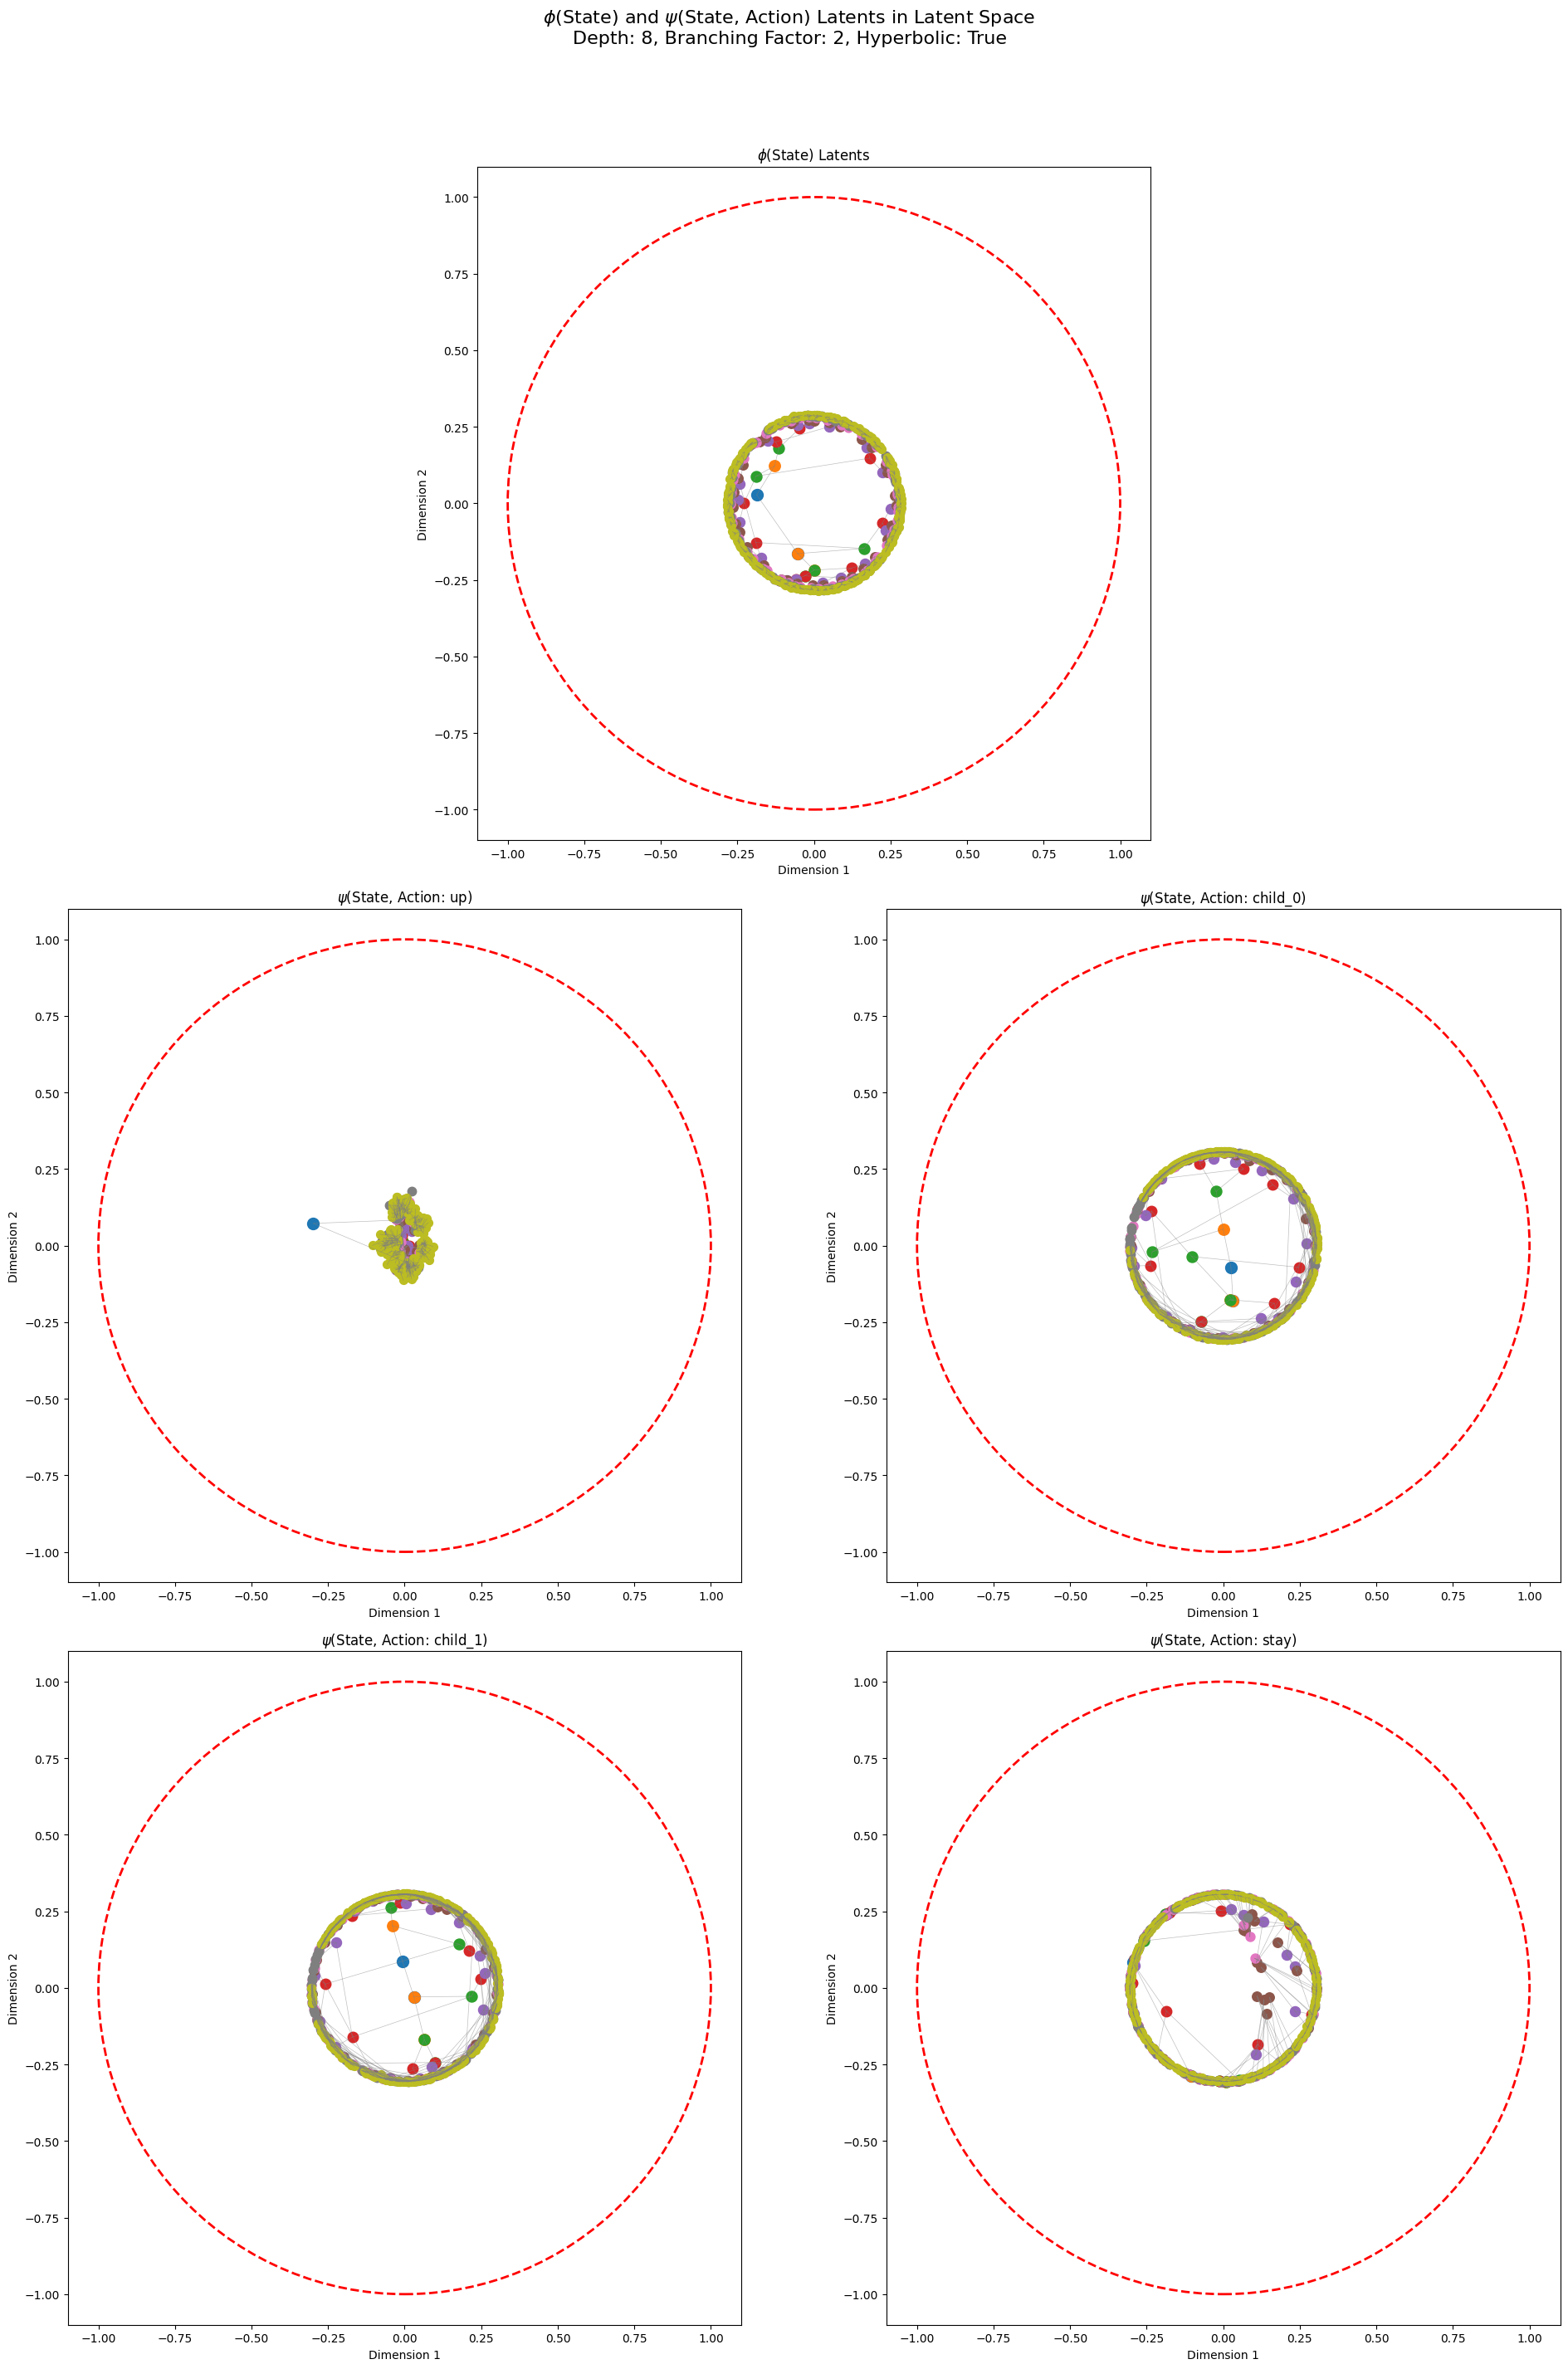

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from matplotlib import gridspec

# Main plotting code
num_actions = branching_factor + 2
max_depth = int(np.log(env.num_nodes) / np.log(branching_factor))
sizes = np.linspace(100, 50, max_depth + 1)

# Calculate the number of rows needed for action plots
num_action_rows = math.ceil(num_actions / 2)

# Create figure
fig = plt.figure(figsize=(20, 10 * (num_action_rows + 1)))

# Create grid layout
gs = gridspec.GridSpec(num_action_rows + 1, 2, height_ratios=[1] + [1]*num_action_rows)

fig.suptitle(r"$\phi$(State) and $\psi$(State, Action) Latents in Latent Space" + 
             f"\nDepth: {max_depth}, Branching Factor: {branching_factor}, Hyperbolic: {hyperbolic}", 
             fontsize=16)

# Plot state latents in the top row, centered
ax_state = fig.add_subplot(gs[0, :])
with torch.no_grad():
    nodes = torch.arange(env.num_nodes)[:, None]
    latents = encoder2(nodes)
    if hyperbolic:
        latents = latents.tensor
plot_latents(ax_state, latents, title=r"$\phi$(State) Latents")
ax_state.set_title(r"$\phi$(State) Latents")

# Plot action latents
for a in range(num_actions):
    row = (a // 2) + 1  # +1 because the first row is for state latents
    col = a % 2
    ax = fig.add_subplot(gs[row, col])
    
    action_name = env.action_map[a]
    
    with torch.no_grad():
        nodes = torch.arange(env.num_nodes)[:, None]
        actions = torch.cat([nodes, torch.full(nodes.shape, a)], dim=-1)
        latents = encoder1(actions)
        if hyperbolic:
            latents = latents.tensor
        plot_latents(ax, latents, title=f"$\psi$(State, Action: {action_name})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

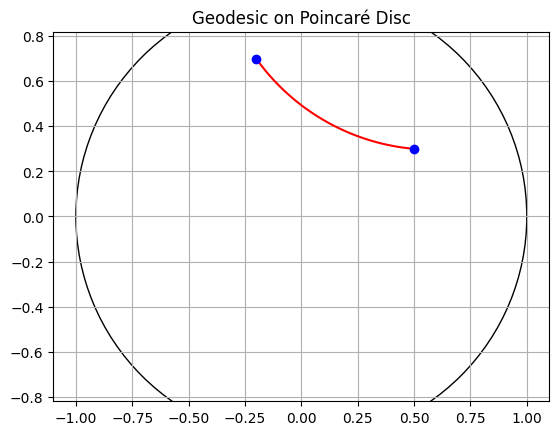

In [129]:
import numpy as np
import matplotlib.pyplot as plt

def mobius_addition(z1, z2, theta=0):
    numerator = z1 + np.exp(1j * theta) * z2
    denominator = 1 + np.conj(z1) * np.exp(1j * theta) * z2
    return numerator / denominator

def geodesic_points(z1, z2, t):
    a = mobius_addition(-z1, z2, 0)  # theta=0 for geodesics
    return mobius_addition(z1, t * a, 0)

def plot_poincare_geodesic(p1, p2):
    z1 = p1[0] + 1j*p1[1]
    z2 = p2[0] + 1j*p2[1]
    
    # Plot the Poincaré disc boundary
    circle = plt.Circle((0, 0), 1, fill=False)
    plt.gca().add_artist(circle)
    
    # Generate points along the geodesic
    t = np.linspace(0, 1, 100)
    geodesic = geodesic_points(z1, z2, t)
    
    # Plot the geodesic
    plt.plot(geodesic.real, geodesic.imag, 'r-')
    
    # Plot the points
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'bo')
    
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.title('Geodesic on Poincaré Disc')
    plt.grid(True)
    plt.show()

# Example usage
p1 = (0.5, 0.3)
p2 = (-0.2, 0.7)
plot_poincare_geodesic(p1, p2)

In [130]:
state = int(anchor[0])

a = torch.full((3,1), state)

NameError: name 'anchor' is not defined

In [ ]:
exclude_index = 2

v = torch.cat([
        torch.arange(0, exclude_index),
        torch.arange(exclude_index + 1, env.branching_factor + 2)
    ])

In [ ]:
torch.cat([a , v.unsqueeze(-1)], dim=-1)

In [131]:
import torch
import torch.nn as nn

class CategoricalMLP(nn.Module):
    def __init__(self, cat_features, embedding_dims, hidden_dims, output_dim):
        super(CategoricalMLP, self).__init__()
        
        # Embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim) 
            for num_categories, emb_dim in zip(cat_features, embedding_dims)
        ])
        
        # Calculate total embedding dimension
        total_emb_dim = sum(embedding_dims)
        
        # Fully connected layers
        layers = []
        input_dim = total_emb_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        
        layers.append(nn.Linear(input_dim, output_dim))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        # x should be a list of tensors, one for each categorical feature
        embeddings = [emb_layer(x[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        concat_embeddings = torch.cat(embeddings, dim=1)
        return self.mlp(concat_embeddings)

# Example usage
cat_features = [10, 20, 15]  # Number of categories for each feature
embedding_dims = [5, 8, 6]   # Embedding dimensions for each feature
hidden_dims = [64, 32]       # Hidden layer dimensions
output_dim = 10              # Final output dimension

model = CategoricalMLP(cat_features, embedding_dims, hidden_dims, output_dim)

# Example input (batch_size = 3, num_features = 3)
x = torch.tensor([[1, 5, 3],
                  [4, 2, 7],
                  [9, 15, 2]])

output = model(x)
print(output.shape)  # Should be torch.Size([3, 10])

torch.Size([3, 10])


In [132]:
def eval_tree(
    depth,
    branching_factor,
    num_trials,
    encoder1,
    encoder2,
    manifold,
    device,
    max_steps=100,
    hyperbolic=False,
    verbose=False,
):
    """
    Run policy on maze, collect failure metrics
    """
    

    results = []
    for i in range(num_trials):
        with torch.no_grad():
            env = NaryTreeEnvironment(depth=depth, branching_factor=branching_factor)
            
            start, end = np.random.randint(0, env.num_nodes, size=2)
            
            goal = torch.tensor(end).to(device).unsqueeze(0)
            # if hyperbolic:
            #     goal = manifold_map(goal, manifold=manifold)
            goal = encoder2(goal)

            # print(f'start: {start}, goal: {goal}')

            def reached(cur_pos, goal_pos):
                return cur_pos == goal_pos

            def step():
                cur_pos = env.agent_position
                if verbose:
                    print(f"cur_pos: {cur_pos}, goal: {goal}")
                activations = []
                angles = torch.linspace(0.0, 2 * torch.pi, 16)
                
                actions = [i for i in range(branching_factor + 2)]
                for a in actions:
                    cur = torch.tensor(
                        [env.agent_position, a]
                    ).to(device)

                    cur = encoder1(cur)

                    # MANIFOLD EVAL
                    if config['hyperbolic']:
                        activations.append((a, -manifold.dist(x=cur, y=goal)))
                    else:
                        activations.append((a, -torch.norm(cur - goal)))

                best_action = activations[np.argmax([x[1].cpu() for x in activations])][
                    0
                ]
                env.move_agent(best_action)
                if verbose:
                    print(f'agent position: {env.agent_position}')

            def SPL(
                start, end, num_steps, success
            ):  # Success weighted by (normalized inverse) Path Length
                if not success:
                    return 0
                else:
                    p = num_steps
                    l = len(env.get_action_path(start, end))
                    return l / max(p, l)

            steps = 0
            while not reached(env.agent_position, end):
                if steps > max_steps:
                    break
                step()
                steps += 1

            result = (
                not reached(env.agent_position, end),
                steps,
                SPL(start, end, steps, reached(env.agent_position, end)),
            )
            if verbose:
                print(reached(env.agent_position, end))
                print(
                    f"start: {start}, goal: {end}, end_pos: {env.agent_position}, steps: {steps}"
                )
                print(results)

            results.append(result)

    return results

In [133]:
evals = eval_tree(depth, branching_factor, 100, encoder1, encoder2, manifold, device, max_steps=50, verbose=False)

acc = np.mean([x[2] for x in evals])
fail = np.mean([x[0] for x in evals])

print(f'SPL: {acc}, Fail %: {fail}')

SPL: 0.8373333333333334, Fail %: 0.13
